## A2b : IPL Performance vs Salary

Name : Aakash Kathirvel

VID : V01110153

Date : 06/23/2024

Import necessary libraries

In [25]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm
from fuzzywuzzy import process, fuzz  # For approximate string matching
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Set the working directory
os.chdir('C:/Users/Aakash/Desktop/SCMA')

In [27]:
# Function to install and load libraries
def install_and_import(package):
    import importlib
    try:
        importlib.import_module(package)
    except ImportError:
        import pip
        pip.main(['install', package])
    finally:
        globals()[package] = importlib.import_module(package)

In [26]:
# Install and import necessary libraries
libraries = ["pandas", "numpy", "scipy", "statsmodels", "fuzzywuzzy", "matplotlib", "seaborn"]
for lib in libraries:
    install_and_import(lib)

Load the Dataset

In [29]:
df_ipl = pd.read_csv("IPL_ball_by_ball_updated till 2024.csv")

C:\Users\Aakash\AppData\Local\Temp\ipykernel_232\2851011031.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ipl = pd.read_csv("IPL_ball_by_ball_updated till 2024.csv")


In [30]:
salary = pd.read_excel("IPL SALARIES 2024.xlsx")

In [31]:
df_ipl.columns

Index(['Match id', 'Date', 'Season', 'Batting team', 'Bowling team',
       'Innings No', 'Ball No', 'Bowler', 'Striker', 'Non Striker',
       'runs_scored', 'extras', 'type of extras', 'score', 'score/wicket',
       'wicket_confirmation', 'wicket_type', 'fielders_involved',
       'Player Out'],
      dtype='object')

In [32]:
# Group and aggregate the performance metrics for runs scored
total_runs_each_year = df_ipl.groupby(['Season', 'Striker']).agg({'runs_scored': 'sum'}).reset_index()
total_runs_each_year

,Season,Striker,runs_scored
0,2012,A Ashish Reddy,35
1,2012,A Chandila,0
2,2012,A Mishra,10
3,2012,A Nehra,9
4,2012,AA Chavan,7
...,...,...,...
2812,2021,V Kohli,71
2813,2021,V Shankar,42
2814,2021,Virat Singh,11
2815,2021,WP Saha,8


In [17]:
# Function to match names
def match_names(name, names_list, max_dist=0.2):
    match = process.extractOne(name, names_list, scorer=fuzz.ratio, score_cutoff=max_dist*100)
    if match:
        return match[0]
    else:
        return np.nan

Fitting a Model for Runs

In [18]:
#Matching names and merging with salary data for runs
df_salary_runs = salary.copy()
df_salary_runs['Matched_Player'] = df_salary_runs['Player'].apply(lambda x: match_names(x, total_runs_each_year['Striker'].tolist()))


In [19]:
# Filter out unmatched players
df_salary_runs = df_salary_runs.dropna(subset=['Matched_Player'])

In [20]:
# Merge the DataFrames
df_merged_runs = pd.merge(df_salary_runs, total_runs_each_year, left_on='Matched_Player', right_on='Striker')

In [21]:
# Subset data for the last three years
df_merged_runs = df_merged_runs[df_merged_runs['Season'].isin(["2021", "2022", "2023"])]


In [22]:
# Perform regression analysis for runs scored
X_runs = df_merged_runs[['runs_scored']]
y_runs = df_merged_runs['Rs']

In [23]:
# Add constant to X
X_runs = sm.add_constant(X_runs)

In [24]:
# Fit the model
model_runs = sm.OLS(y_runs, X_runs).fit()
print("\n=== Regression Analysis for Runs Scored ===")
print(model_runs.summary())


=== Regression Analysis for Runs Scored ===
                            OLS Regression Results                            
Dep. Variable:                     Rs   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.410
Date:                Sun, 23 Jun 2024   Prob (F-statistic):              0.240
Time:                        22:39:15   Log-Likelihood:                -420.12
No. Observations:                  55   AIC:                             844.2
Df Residuals:                      53   BIC:                             848.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const

In [34]:
# Evaluate the model for runs scored
y_pred_runs = model_runs.predict(X_runs)
r2_runs = pearsonr(y_runs, y_pred_runs)[0]**2
print("R-squared for runs scored:", r2_runs)


R-squared for runs scored: 0.025913919638669795


Fitting a Model for Wickets

In [35]:
# Group and aggregate the performance metrics for wickets taken
total_wicket_each_year = df_ipl.groupby(['Season', 'Bowler']).agg({'wicket_confirmation': 'sum'}).reset_index()

In [36]:
# Matching names and merging with salary data for wickets
df_salary_wickets = salary.copy()
df_salary_wickets['Matched_Player'] = df_salary_wickets['Player'].apply(lambda x: match_names(x, total_wicket_each_year['Bowler'].tolist()))


In [37]:
# Filter out unmatched players
df_salary_wickets = df_salary_wickets.dropna(subset=['Matched_Player'])

In [38]:
# Merge the DataFrames
df_merged_wickets = pd.merge(df_salary_wickets, total_wicket_each_year, left_on='Matched_Player', right_on='Bowler')

In [39]:
# Subset data for the last three years
df_merged_wickets = df_merged_wickets[df_merged_wickets['Season'].isin(["2021", "2022", "2023"])]

In [40]:
# Perform regression analysis for wickets taken
X_wickets = df_merged_wickets[['wicket_confirmation']]
y_wickets = df_merged_wickets['Rs']

In [41]:
# Add constant to X
X_wickets = sm.add_constant(X_wickets)

In [42]:
# Fit the model
model_wickets = sm.OLS(y_wickets, X_wickets).fit()
print("\n=== Regression Analysis for Wickets Taken ===")
print(model_wickets.summary())


=== Regression Analysis for Wickets Taken ===
                            OLS Regression Results                            
Dep. Variable:                     Rs   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.037
Date:                Sun, 23 Jun 2024   Prob (F-statistic):              0.161
Time:                        22:45:11   Log-Likelihood:                -317.96
No. Observations:                  42   AIC:                             639.9
Df Residuals:                      40   BIC:                             643.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [43]:
# Evaluate the model for wickets taken
y_pred_wickets = model_wickets.predict(X_wickets)
r2_wickets = pearsonr(y_wickets, y_pred_wickets)[0]**2
print("R-squared for wickets taken:", r2_wickets)

R-squared for wickets taken: 0.04844901942295737


Plotting the relationship between Runs Scored and Salary

<Axes: xlabel='runs_scored', ylabel='Rs'>

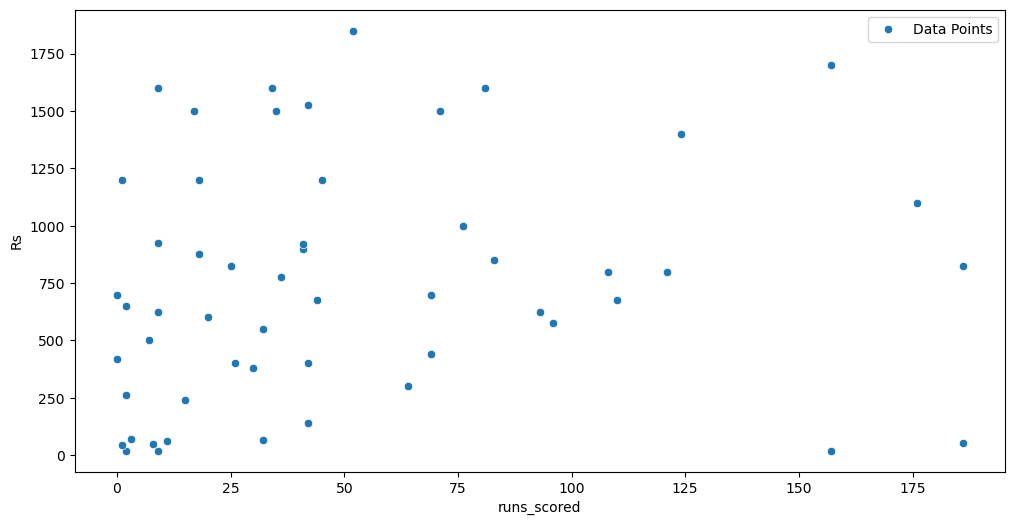

In [45]:
# Plotting the relationship between Runs Scored and Salary
plt.figure(figsize=(12, 6))
sns.scatterplot(x='runs_scored', y='Rs', data=df_merged_runs, label='Data Points')

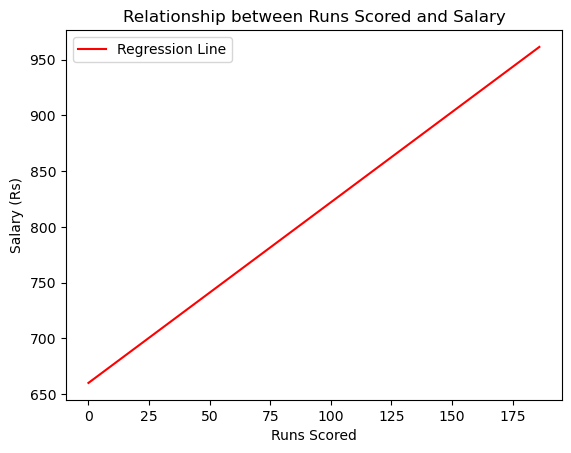

In [46]:
# Creating a DataFrame for the regression line
regression_data_runs = pd.DataFrame({'runs_scored': X_runs['runs_scored'], 'predicted_salary': y_pred_runs})
sns.lineplot(x='runs_scored', y='predicted_salary', data=regression_data_runs, color='red', label='Regression Line')
plt.title('Relationship between Runs Scored and Salary')
plt.xlabel('Runs Scored')
plt.ylabel('Salary (Rs)')
plt.legend()
plt.show()

Plotting the relationship between Wickets Taken and Salary

<Axes: xlabel='wicket_confirmation', ylabel='Rs'>

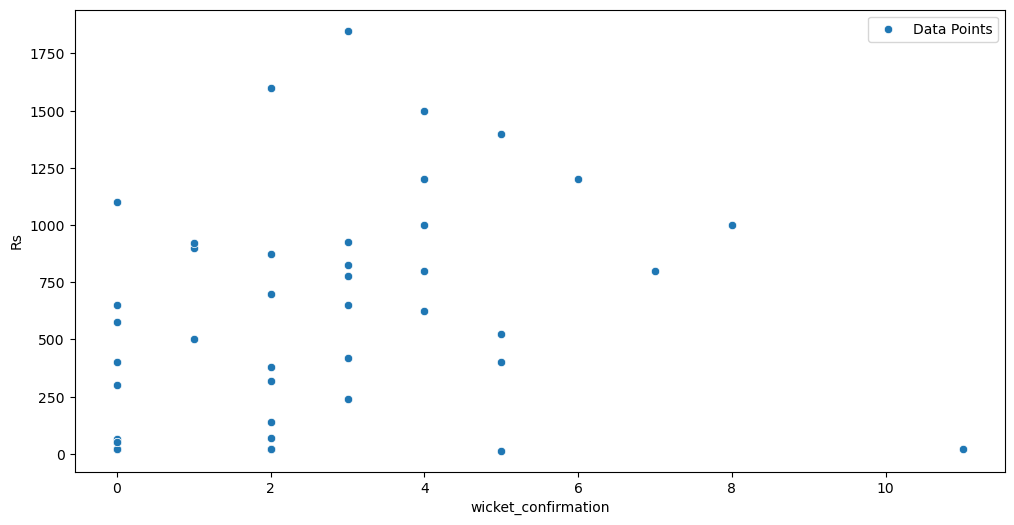

In [47]:
# Plotting the relationship between Wickets Taken and Salary
plt.figure(figsize=(12, 6))
sns.scatterplot(x='wicket_confirmation', y='Rs', data=df_merged_wickets, label='Data Points')

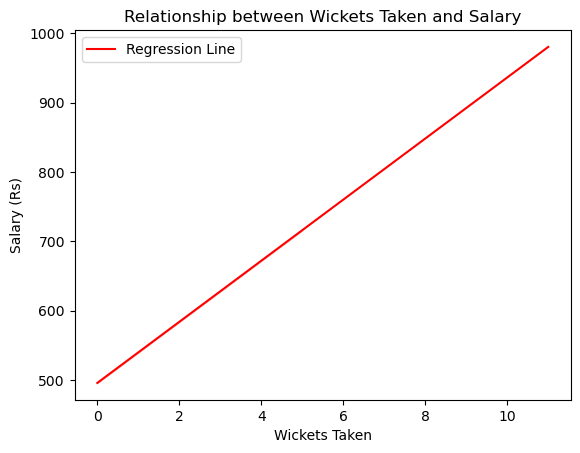

In [48]:
# Creating a DataFrame for the regression line
regression_data_wickets = pd.DataFrame({'wicket_confirmation': X_wickets['wicket_confirmation'], 'predicted_salary': y_pred_wickets})
sns.lineplot(x='wicket_confirmation', y='predicted_salary', data=regression_data_wickets, color='red', label='Regression Line')
plt.title('Relationship between Wickets Taken and Salary')
plt.xlabel('Wickets Taken')
plt.ylabel('Salary (Rs)')
plt.legend()
plt.show()